In this notebook we want to try the fitter (using minuit) on WCSim data. First get the data in a usable format...

In [3]:
geo_path = '/eos/user/j/jrimmer/Geometry'
import sys
sys.path.insert(0, geo_path)
sys.path.insert(0, "../")
sys.path.insert(0, "../LicketyFit")
from Geometry.Device import Device

from LicketyFit.Event import *
from LicketyFit.PMT import *
from LicketyFit.MarkovChain import *
from LicketyFit.Emitter import *

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import uproot, json, awkward as ak
from read_sim_data import *

In [4]:
# Load in wcsim npz file

#folder = "/eos/user/j/jrimmer/sim_work_dir/WCSim/sim_data/mu/1kmu_400MeV_noScatMu_or_ph.npz"
#folder = "/eos/user/j/jrimmer/sim_work_dir/WCSim/1kmu_300MeV_x0y0zn1000_noScatMu_or_ph.npz"
#folder = "/eos/user/j/jrimmer/sim_work_dir/WCSim/sim_data/mu/1kmu-_300MeV_noairgap.npz"


folder = "/eos/user/j/jrimmer/sim_work_dir/WCSim/1kmu_300MeV_x0y0zn1000.npz"

# Get the mapping between wcsim and wcte PMT positions
wcte_mapping = np.loadtxt('../tables/wcsim_wcte_mapping.txt')

# wcsim uses positions 1-19, so have to subtract 1 in the mapping...
sim_wcte_mapping = {}
for i in range(len(wcte_mapping)):
    sim_wcte_mapping[int(wcte_mapping[i][0])] = int(wcte_mapping[i][1]*100 + wcte_mapping[i][2] - 1)
    
    
data_raw = read_sim_data(folder)

In [5]:
pmts = []

for i in range(len(data_raw['digi_hit_pmt'])):
    for j in range(len(data_raw['digi_hit_pmt'][i])):
        pmts.append(data_raw['digi_hit_pmt'][i][j])
        
len(np.unique(pmts))

1843

In [6]:
data_raw.keys()

dict_keys(['true_hit_pmt', 'true_hit_time', 'digi_hit_pmt', 'digi_hit_time', 'track_start_position', 'track_stop_position', 'track_id', 'track_pid', 'track_start_time', 'digi_hit_charge', 'position', 'direction', 'energy', 'track_energy', 'track_boundary_kes'])

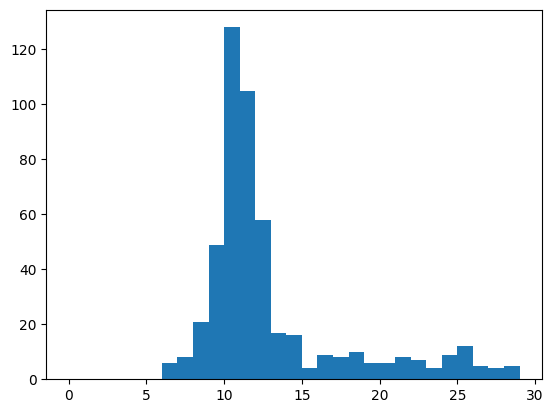

In [7]:
evt_num = 29
plt.hist(data_raw['digi_hit_time'][evt_num],bins = np.arange(0,30));

In [8]:

cut_time = 15

data = {'digi_hit_pmt':[],'digi_hit_time':[],'digi_hit_charge':[]}
for i in range(len(data_raw['digi_hit_time'][evt_num])):
    if 0<data_raw['digi_hit_time'][evt_num][i]<cut_time:
        data['digi_hit_time'].append(data_raw['digi_hit_time'][evt_num][i])
        data['digi_hit_pmt'].append(data_raw['digi_hit_pmt'][evt_num][i])
        data['digi_hit_charge'].append(data_raw['digi_hit_charge'][evt_num][i])

In [9]:
#inactive_slots = [9,17,27,32,45,74,77,79,85,91,99,102]
inactive_slots = [27,32,45,74,77,79,85,91,99]
def sim_to_Event(sim_data, n_mpmt_total=None, pe_scale=1.0, shift_times=False):
    """
    Convert one raw JSON event into Dean's Event class.

    Parameters
    ----------
    raw : dict
        One decoded JSON entry, containing:
            hit_mpmt_slot_ids
            hit_pmt_position_ids
            hit_pmt_charges
            hit_pmt_times
            run_id
            event_number
    n_mpmt_total : int or None
        If None, inferred from max slot ID + 1.  
        If geometry index space is full (0–105), set this to 106.
    pe_scale : float
        ADC counts per 1 PE (for later use)
    shift_times : bool
        Whether to subtract earliest hit time to make event times relative.

    Returns
    -------
    Event object
    """

    # ---------
    # Determine total number of mPMTs
    # ---------
    slots = []
    pmt_pos_ids = []
    charges = []
    times = []
    for i in range(len(sim_data['digi_hit_pmt'])):
        
        sim_pmt = sim_data['digi_hit_pmt'][i]
        wcte_pmt = sim_wcte_mapping[sim_data['digi_hit_pmt'][i]+1]
        slots.append(int(wcte_pmt/100))
        pmt_pos_ids.append(wcte_pmt%100)
        charges.append(sim_data['digi_hit_charge'][i])
        times.append(sim_data['digi_hit_time'][i])
        
    #slots = raw["hit_mpmt_slot_ids"]
    if n_mpmt_total is None:
        n_mpmt = int(np.max(slots)) + 1
    else:
        n_mpmt = n_mpmt_total

    # Create event
    ev = Event(0, 0, n_mpmt)

    # Activate all PMTs
    wcte_pmt_ids = []
    ev.set_mpmt_status(list(range(n_mpmt)), True)
    for i_mpmt in range(n_mpmt):
        if i_mpmt in inactive_slots:
            ev.set_pmt_status(i_mpmt, list(range(ev.npmt_per_mpmt)), False)
        else:
            ev.set_pmt_status(i_mpmt, list(range(ev.npmt_per_mpmt)), True)
            for j in range(19):
                wcte_pmt_ids.append(i_mpmt*100+j)

    # Fill hits
    for s, p, q, t in zip(slots,
                          pmt_pos_ids,
                          charges,
                          times):
        ev.hit_times[s][p].append(float(t))
        ev.hit_charges[s][p].append(float(q))

    # -------------
    # TIME SHIFTING (this is new)
    # -------------
    if shift_times:
        min_time = float('inf')
        for i_mpmt in range(ev.n_mpmt):
            for i_pmt in range(ev.npmt_per_mpmt):
                if ev.hit_times[i_mpmt][i_pmt]:
                    tmin = min(ev.hit_times[i_mpmt][i_pmt])
                    if tmin < min_time:
                        min_time = tmin

        # Shift all hit times so earliest hit = 0 ns
#         if min_time < float('inf'):
#             for i_mpmt in range(ev.n_mpmt):
#                 for i_pmt in range(ev.npmt_per_mpmt):
#                     ev.hit_times[i_mpmt][i_pmt] = [
#                         t - min_time for t in ev.hit_times[i_mpmt][i_pmt]
#                     ]

        # Store original offset for bookkeeping if needed
        #ev.global_time_offset = min_time

    return ev, wcte_pmt_ids

In [10]:
ev, pmt_ids = sim_to_Event(data, n_mpmt_total=None, pe_scale=1.0, shift_times=False)


In [11]:
ev.n_mpmt

106

In [12]:
def build_observables_from_event(ev, pe_scale=1.0):
    """
    Build obs_pes and obs_ts from a real Event.

    obs_pes: float npe per PMT (from total charge / pe_scale)
    obs_ts:  first hit time per PMT (or None if no hit)

    Returns:
        obs_pes, obs_ts, pmt_indices
        - obs_pes: np.array of len N_pmts_used
        - obs_ts:  np.array of len N_pmts_used (dtype=object so None allowed)
        - pmt_indices: list of (i_mpmt, i_pmt) for each entry
    """
    obs_pes = []
    obs_ts = []
    pmt_indices = []

    for i_mpmt in range(ev.n_mpmt):
        if not ev.mpmt_status[i_mpmt]:
            continue
        for i_pmt in range(ev.npmt_per_mpmt):
            if not ev.pmt_status[i_mpmt][i_pmt]:
                continue

            charges = ev.hit_charges[i_mpmt][i_pmt]
            times   = ev.hit_times[i_mpmt][i_pmt]

            if len(charges) == 0:
                # no hit in this PMT
                obs_pes.append(0.0)
                obs_ts.append(None)
                pmt_indices.append((i_mpmt, i_pmt))
                continue

            # crude PE estimate: total charge / single-PE scale
            total_q = np.sum(charges)
            npe = total_q / pe_scale

            # take earliest hit as "time" of this PMT
            t_first = float(np.min(times))

            obs_pes.append(float(npe))
            obs_ts.append(t_first)
            pmt_indices.append((i_mpmt, i_pmt))

    # use dtype=object so that None is allowed (if you ever keep Nones)
    return np.array(obs_pes, dtype=float), np.array(obs_ts, dtype=object), pmt_indices

In [13]:
obs_pes, obs_ts, pmt_indices = build_observables_from_event(ev, pe_scale=1.0)
print("Using", len(obs_pes), "PMTs in likelihood")

Using 1843 PMTs in likelihood


In [14]:
np.mean(obs_pes)

np.float64(0.8266361082499272)

In [15]:
# single_pe_amp_mean = 1.    # arbitrary initial values; tune to match data
# single_pe_amp_std  = 0.3
# single_pe_time_std = 1.0
# separation_time    = 20.
# amp_threshold      = 0.2
# noise_rate         = 0.

single_pe_amp_mean = 60.
single_pe_amp_std = 20.
single_pe_time_std = 1.
separation_time = 40.
amp_threshold = 20.
noise_rate = 0.
pmt = PMT(single_pe_amp_mean, single_pe_amp_std, single_pe_time_std, separation_time, amp_threshold, noise_rate)

pmt_model = PMT(single_pe_amp_mean,
                single_pe_amp_std,
                single_pe_time_std,
                separation_time,
                amp_threshold,
                noise_rate)

In [17]:
# initial guess (it will be varied by MCMC)
init_E_vs_dist_travelled = np.load('../tables/init_E_vs_dist_travelled.npy')
dist_travelled = init_E_vs_dist_travelled[:,0]
init_energy = init_E_vs_dist_travelled[:,1]

length_guess = np.interp(300,init_energy,dist_travelled*10)
starting_time_guess = 0
start_coord_guess   = (0.0, 0, -1000)   # mm
direction_guess     = (0.0, 0.0, 1.0)   # along +z
beta_guess          = 0.96
length_guess        = length_guess          # mm
intensity_guess     = 10.0               # PE at 1 m, normal incidence

emitter_model = Emitter(starting_time_guess,
                        start_coord_guess,
                        direction_guess,
                        beta_guess,
                        length_guess,
                        intensity_guess)

COSINE 0.7787590119109392
INIT ENERGY 300.0
BETA VALUE IS 0.9654844281071472


In [19]:
hall = Device.open_file(geo_path+'/examples/wcte_bldg157.geo')
wcte = hall.wcds[0]
n_mpmt_geom = len(wcte.mpmts)
print("Geometry has", n_mpmt_geom, "mPMTs")

Geometry has 106 mPMTs


In [20]:
init_E_vs_dist_travelled = np.load('../tables/init_E_vs_dist_travelled.npy')
dist_travelled = init_E_vs_dist_travelled[:,0]
init_energy = init_E_vs_dist_travelled[:,1]

In [21]:
corr_pos = None
emitter_copy = emitter_model.copy()
p_locations, direction_zs = emitter_copy.get_pmt_placements(ev, wcte, 'design')
init_KE = np.interp(length_guess, dist_travelled*10, init_energy) # Convert distance to mm
ss = emitter_copy.get_emission_points(p_locations,init_KE)
exp_pes, exp_ts = emitter_copy.get_expected_pes_ts(wcte, ss, p_locations, direction_zs,corr_pos,obs_pes)

In [23]:
import numpy as np
import matplotlib
import sys

sys.path.insert(0, "../event_display")
sys.path.insert(0, "../")
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
from EventDisplay import EventDisplay
import matplotlib.colors as colors

#from Geometry.Device import Device

from LicketyFit.Emitter import Emitter
from LicketyFit.Event import SimulatedEvent
from LicketyFit.PMT import PMT
from LicketyFit.Fitter import Fitter

#1) make an instance of the event display class
eventDisplay = EventDisplay() 

#2) start by loading in the CSV file for how the mPMTs are mapped to 2d event display
#unwraps based on the mPMT slot ID 
eventDisplay.load_mPMT_positions('mPMT_2D_projection_angles.csv')

#mask out mPMT slots - newer WCSim doesn't have these mPMTs loaded  
#WCTE slot numbering
# eventDisplay.mask_mPMTs([45,77,79,27,32,85,91,99,12,14,16,18])
#WCSim container numbering
# eventDisplay.mask_mPMTs([20,73,38,49,55,65,67,33,71,92,101,95])

#3) load the WCSim mapping tube no to slot number
#for WCSim using the numpy output we need the mapping between the tube_number in WCSim and the slot and mPMT number in the detector
#this can be obtained from the geofile that WCSim produces 
#This changes if the CDS is implemented or not
eventDisplay.load_wcsim_tubeno_mapping("geofile_WCTE.txt")

#4) debug by plotting some geometry files 
#data = np.load("/eos/home-j/jrimmer/sim_work_dir/WCSim/300mu_500MeV_airgap.npz", allow_pickle=True)
#data = np.load("/eos/home-j/jrimmer/sim_work_dir/WCSim/wcsim.npz", allow_pickle=True)


#position = data["position"]

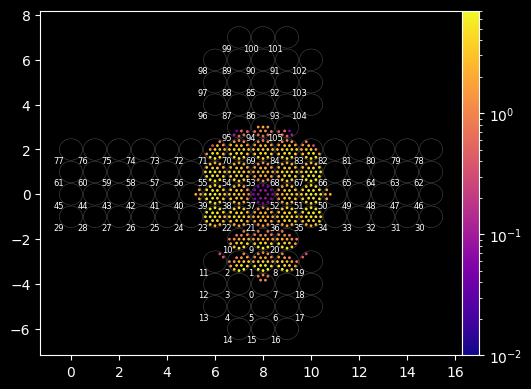

In [24]:
#load the data to plot

eventID =0

#mask = data["digi_hit_time"][eventID] < 20

#tube_no = data["digi_hit_pmt"]

data_to_plot = exp_pes


#pmt = np.asarray(data["digi_hit_pmt"])
#charge = np.asarray(data["digi_hit_charge"])

mPMT_id = []
PMT_pos = []

for i in range(len(pmt_ids)):
    mPMT_id.append(int(pmt_ids[i]/100))
    PMT_pos.append(int(pmt_ids[i]%100))

#map from the tube number to the mPMT slot and position number
#mPMT_id, PMT_pos = eventDisplay.map_wcsim_tubeno_to_slot_pmt_id(tube_no)
data_to_plot = eventDisplay.process_data(mPMT_id,PMT_pos,data_to_plot)
#x = eventDisplay.plotEventDisplay(data_to_plot,color_norm=colors.Normalize(), style= "dark_background")
x = eventDisplay.plotEventDisplay(data_to_plot, vmax=7,vmin=0.01,log_scale=True,style= "dark_background")

In [25]:
corr_pos = {'wut':np.array([]),'delam':np.array([])}
corr_pos = None
def get_neg_log_likelihood_npe_t(x0, y0, z0, cx, cy, length, t0):
    # build direction unit vector
    cz = np.sqrt(1.0 - cx**2 - cy**2)
    direction = (cx, cy, cz)
    start_coord = (x0, y0, z0)
    
    #emitter_copy.intensity = intensity
    # update emitter model
    emitter_copy.start_coord   = start_coord
    emitter_copy.starting_time = t0
    emitter_copy.direction     = direction
    emitter_copy.length        = length

    init_KE = np.interp(length, dist_travelled*10, init_energy) # Convert distance to mm
    # expected number of PE and times at each PMT
    ss = emitter_copy.get_emission_points(p_locations,init_KE)
    #print(ss[0])
    #print('')
    exp_pes, exp_ts = emitter_copy.get_expected_pes_ts(wcte, ss, p_locations, direction_zs,corr_pos,obs_pes)
    #print(np.mean(exp_pes))
    
    #pe_scaling_factor = np.mean(obs_pes)/np.mean(exp_pes)
    
    #exp_pes = np.array(exp_pes)*pe_scaling_factor
    
    
   
    #print(np.mean(exp_pes))
    # compare to observed data using the PMT-likelihood model
    neg_ll = pmt_model.get_neg_log_likelihood_npe_t(exp_pes, obs_pes, exp_ts, obs_ts)
    
    # DEBUG GUARD:
#     if not np.isfinite(neg_ll):
#         print("Non-finite neg_ll:",
#               neg_ll,
#               "params:",
#               x0, y0, z0, cx, cy, length, t0)
#         return 1e30

    return float(neg_ll)


In [26]:
np.mean(obs_pes)

np.float64(0.8266361082499272)

In [27]:
from minuit_fit import *

x0_init = 0
y0_init = 0
z0_init = -800
cx_init = 0.0
cy_init = 0.0
length_init = 500
t0_init = 0

m = Minuit(
        get_neg_log_likelihood_npe_t,
        x0=x0_init,
        y0=y0_init,
        z0=z0_init,
        cx=cx_init,
        cy=cy_init,
        length=length_init,
        t0=t0_init
    )

m.limits["x0"] = (-2000, 2000)
m.limits["y0"] = (-2000, 2000)
m.limits["z0"] = (-2000, 2000)
m.limits["cx"] = (-0.5, 0.5)
m.limits["cy"] = (-0.5, 0.5)
m.limits["length"] = (0, 3000)   
m.limits["t0"] = (-10, 10)
#m.limits["intensity"] = (0,30)

m.errors["x0"] = 20.0
m.errors["y0"] = 20.0
m.errors["z0"] = 20.0
m.errors["cx"] = 0.01
m.errors["cy"] = 0.01
m.errors["length"] = 50.0
m.errors["t0"] = 0.5

In [28]:
m.errordef = Minuit.LIKELIHOOD
m.strategy = 1  # more careful

#m.simplex()
m.migrad(ncall=3000)



/cvmfs/sft.cern.ch/lcg/views/LCG_108_swan/x86_64-el9-gcc13-opt/lib/python3.12/site-packages/iminuit/_repr_html.py:277: RuntimeWarning: invalid value encountered in scalar power
  dj = arr[j, j] ** 0.5
/cvmfs/sft.cern.ch/lcg/views/LCG_108_swan/x86_64-el9-gcc13-opt/lib/python3.12/site-packages/iminuit/_repr_html.py:274: RuntimeWarning: invalid value encountered in scalar power
  di = arr[i, i] ** 0.5


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 173.9                      │             Nfcn = 4084              │
│ EDM = 1.79e+08 (Goal: 0.0001)    │           time = 13.4 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │   ABOVE EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │        Covariance APPROXIMATE        │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0     │ -20.0624  │  0.0023   │            │            │  -2000  │  2000   │       │
│ 1 │ y0     │  28.2614  │  0.0010   │            │            │  -2000  │  2000   │       │
│ 2 │ z0     │ -1.118e3  │    nan    │            │            │  -2000  │  2000   │       │
│ 3 │ cx     │ 1.0919e-3 │ 0.0009e-3 │            │            │  -0.5   │   0.5   │       │
│ 4 │ cy     │8.74753e-3 │0.00025e-3 │            │            │  -0.5   │   0.5   │       │
│ 5 │ length │ 8.5347e2  │    nan    │            │            │    0    │  3000   │       │
│ 6 │ t0     │  -0.151   │   0.026   │            │            │   -10   │   10    │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬─────────────────────────────────────────────────────────────────────────────────────┐
│        │          x0          y0          z0          cx          cy      length          t0 │
├────────┼─────────────────────────────────────────────────────────────────────────────────────┤
│     x0 │    5.54e-06     -0.5e-6   -0.005e-6  -1.7072e-9          -0      0.9e-9        0e-6 │
│     y0 │     -0.5e-6     1.1e-06    0.005e-6  -181.1e-12 -199.55e-12     -0.9e-9          -0 │
│     z0 │   -0.005e-6    0.005e-6   -2.15e-08    -1.9e-12           0      3.8e-9          -0 │
│     cx │  -1.7072e-9  -181.1e-12    -1.9e-12    7.76e-13          -0     0.4e-12     3.6e-12 │
│     cy │          -0 -199.55e-12           0          -0    6.39e-14          -0           0 │
│ length │      0.9e-9     -0.9e-9      3.8e-9     0.4e-12          -0   -5.69e-10      0.1e-9 │
│     t0 │        0e-6          -0          -0     3.6e-12           0      0.1e-9    0.000667 │
└────────┴─────────────────────────────────────────────────────────────────────────────────────┘

In [29]:
print(m.fmin)
print("Valid minimum:", m.fmin.is_valid)
print("Hesse ok:", m.fmin.has_accurate_covar)
print("Function calls:", m.nfcn)

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 173.9                      │             Nfcn = 4084              │
│ EDM = 1.79e+08 (Goal: 0.0001)    │           time = 13.4 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │   ABOVE EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │        Covariance APPROXIMATE        │
└──────────────────────────────────┴──────────────────────────────────────┘
Valid minimum: False
Hesse ok: False
Function calls: 4084


In [30]:
print("Initial FCN:", get_neg_log_likelihood_npe_t(
    x0_init, y0_init, z0_init, cx_init, cy_init, length_init, t0_init
))
print("Final FCN:", m.fmin.fval)

Initial FCN: 5795.493066037592
Final FCN: 173.87232361716931


In [33]:
init_E_vs_dist_travelled = np.load('../tables/init_E_vs_dist_travelled.npy')
dist_travelled = init_E_vs_dist_travelled[:,0]
init_energy = init_E_vs_dist_travelled[:,1]

length_t = np.interp(300,init_energy,dist_travelled*10)

x_t= 0
y_t = 0
z_t = -1000
cx_t = 0
cy_t = 0
#length_t = 1700
t_t = 0.

print("True FCN:", get_neg_log_likelihood_npe_t(
    x_t, y_t, z_t, cx_t, cy_t, length_t, t_t
))

True FCN: 851.0936098254599


In [36]:
length_t

np.float64(1165.0)

In [37]:
length = [np.interp(E,init_energy,dist_travelled*10) for E in range(100,400)]
energy = range(100,600)
nll = []

for E in energy:
    l = np.interp(E,init_energy,dist_travelled*10)
    nll.append(get_neg_log_likelihood_npe_t(x_t, y_t, z_t, cx_t, cy_t, l, t_t))

Text(0.5, 1.0, '300 MeV Muon Starting at (0,0,0), Truth Values Used')

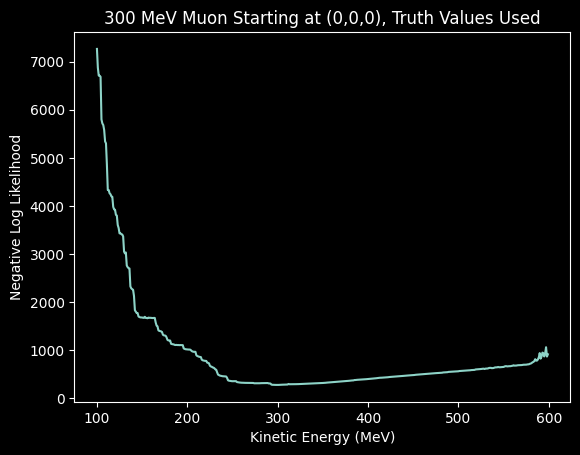

In [38]:
plt.plot(energy, nll)
plt.xlabel('Kinetic Energy (MeV)')
plt.ylabel('Negative Log Likelihood')
plt.title('300 MeV Muon Starting at (0,0,0), Truth Values Used')

In [ ]:
pmt_pos, start_pos, track_dir,
    s_a_mm, s_max_mm,
    theta_c_func,
    #mpmt_bool,
    R_pmt_mm=37.5,
    n_scan=600,
):

In [30]:
corr_pos = None
emitter_copy = emitter_model.copy()
p, direction_zs = emitter_copy.get_pmt_placements(ev, wcte, 'design')
init_KE = np.interp(length_guess, dist_travelled*10, init_energy) # Convert distance to mm
ss = emitter_copy.get_emission_points(p_locations,init_KE)
exp_pes, exp_ts = emitter_copy.get_expected_pes_ts(wcte, ss, p_locations, direction_zs,corr_pos,obs_pes)

In [31]:
from model_muon_cherenkov_collapse import *
# compare old vs new on one event for a subset of PMTs
x0 = np.array([0,0,-1000])
tdir = np.array([0,0,1])
sa = 0
smax = 1165

scale_old, sb_old = find_scale_for_pmts_old(p, x0, tdir, sa, smax, theta_c_func, n_scan=600)
scale_new, sb_new = find_scale_for_pmts    (p, x0, tdir, sa, smax, theta_c_func, n_scan=600)

print(np.nanmax(np.abs(scale_old - scale_new)))
print(np.nanmax(np.abs(sb_old - sb_new)))


0.0
0.0


In [26]:
scale_old

array([0., 0., 0., ..., 0., 0., 0.])

In [27]:
scale_new

array([0.       , 0.       , 0.9027264, ..., 0.       , 0.       ,
       0.       ])

In [195]:
length_t

np.float64(1145.0)

In [196]:
ev.expected_hit_times

AttributeError: 'Event' object has no attribute 'expected_hit_times'

In [17]:
data_raw['digi_hit_time'][0]

array([-1897.5,     3.5,     3.4, ...,  1919.1,  2142.9,  2888.4],
      dtype=float32)

In [31]:
events = []
obs_pes_list = []
obs_ts_list = []
for evt_num in range(50):
    #print('Event Number',evt_num)
    
    
    cut_time = 20

    data = {'digi_hit_pmt':[],'digi_hit_time':[],'digi_hit_charge':[]}
    for i in range(len(data_raw['digi_hit_time'][evt_num])):
        if 0<data_raw['digi_hit_time'][evt_num][i]<cut_time:
            data['digi_hit_time'].append(data_raw['digi_hit_time'][evt_num][i])
            data['digi_hit_pmt'].append(data_raw['digi_hit_pmt'][evt_num][i])
            data['digi_hit_charge'].append(data_raw['digi_hit_charge'][evt_num][i])
            

    ev, pmt_ids = sim_to_Event(data, n_mpmt_total=106, pe_scale=1.0, shift_times=False)
    #print(ev)
    
    
    p_locations, direction_zs = emitter_copy.get_pmt_placements(ev, wcte, 'design')

    obs_pes, obs_ts, pmt_indices = build_observables_from_event(ev, pe_scale=1.0)
    obs_pes_list.append(obs_pes)
    obs_ts_list.append(obs_ts)
    
    events.append([obs_pes,obs_ts])

In [33]:
import numpy as np

class EventData:
    def __init__(
        self,
        p_locations,      # (N,3)
        direction_zs,     # (N,3)
        obs_pes,          # (N,)
        obs_ts,           # (N,)
        corr_pos,         # correction dict or None
        wcd,
        pmt_model,
        emitter_template  # emitter instance to COPY per fit
    ):
        self.p_locations = np.asarray(p_locations, dtype=float)
        self.direction_zs = np.asarray(direction_zs, dtype=float)
        self.obs_pes = np.asarray(obs_pes, dtype=float)
        self.obs_ts = np.asarray(obs_ts, dtype=float)
        self.corr_pos = corr_pos

        self.wcd = wcd
        self.pmt_model = pmt_model

        # IMPORTANT: each event owns its own emitter instance
        self.emitter = emitter_template.copy()

    def neg_log_likelihood(self, x0, y0, z0, cx, cy, length, t0):
        # Build direction
        cz = np.sqrt(max(0.0, 1.0 - cx**2 - cy**2))
        direction = (cx, cy, cz)

        # Update emitter state
        self.emitter.start_coord = (x0, y0, z0)
        self.emitter.starting_time = t0
        self.emitter.direction = direction
        self.emitter.length = length

        # Cherenkov geometry
        ss = self.emitter.get_emission_points(self.p_locations)

        # Expected PEs and hit times (Model B already inside here)
        exp_pes, exp_ts = self.emitter.get_expected_pes_ts(
            self.wcd,
            ss,
            self.p_locations,
            self.direction_zs,
            self.corr_pos
        )

        # Likelihood evaluation
        neg_ll = self.pmt_model.get_neg_log_likelihood_npe_t(
            exp_pes,
            self.obs_pes,
            exp_ts,
            self.obs_ts
        )

        return float(neg_ll)


In [43]:
from iminuit import Minuit

def fit_one_event(event, init_params):
    """
    event: EventData instance
    init_params: dict with initial guesses
    """
    m = Minuit(event.neg_log_likelihood, **init_params)
    
    m.limits["x0"] = (-50, 50)
    m.limits["y0"] = (-50, 50)
    m.limits["z0"] = (-1900, -500)
    m.limits["cx"] = (-0.1, 0.1)
    m.limits["cy"] = (-0.1, 0.1)
    m.limits["length"] = (0, 4000)   # now FREE
    m.limits["t0"] = (-5, 5)

    # Optional configuration
    m.errordef = Minuit.LIKELIHOOD
    m.strategy = 1
    m.simplex()
    m.migrad()

    return {
        "values": m.values.to_dict(),
        "errors": m.errors.to_dict(),
        "fval": m.fval,
        "valid": m.valid
    }


In [44]:
from multiprocessing import Pool, cpu_count

def run_all_events(events, init_params, nproc=None):
    if nproc is None:
        nproc = cpu_count()

    args = [(event, init_params) for event in events]

    with Pool(processes=nproc) as pool:
        results = pool.starmap(fit_one_event, args)

    return results

In [45]:
# Build events
events = []
n_events = 10
for i in range(n_events):
    ev = EventData(
        p_locations   = p_locations,
        direction_zs  = direction_zs,
        obs_pes       = obs_pes_list[i],
        obs_ts        = obs_ts_list[i],
        corr_pos      = corr_pos,
        wcd           = wcte,
        pmt_model     = pmt_model,
        emitter_template = emitter_copy
    )
    events.append(ev)

# Initial parameter guesses
init_params = dict(
    x0=0.0,
    y0=0.0,
    z0=-1000.0,
    cx=0.0,
    cy=0.0,
    length=1000.0,
    t0=0.0
)

# Run fits in parallel
results = run_all_events(events, init_params, nproc=8)


In [46]:
results

[{'values': {'x0': 12.872209097481585,
   'y0': -0.1755749381055921,
   'z0': -1823.327921047038,
   'cx': -0.09716072990135993,
   'cy': 0.04391968456908276,
   'length': 1980.421488325065,
   't0': -0.8701501461949551},
  'errors': {'x0': 31.29380862809666,
   'y0': 24.26099824405373,
   'z0': 154.14042131399503,
   'cx': 0.02247416860379507,
   'cy': 0.05768438556522257,
   'length': 1201.6686724177289,
   't0': 1.593885759547705},
  'fval': 1440.948349938709,
  'valid': False},
 {'values': {'x0': 3.545047054348053,
   'y0': 17.346701964887348,
   'z0': -1507.8746905806638,
   'cx': -0.012442882936001567,
   'cy': 0.004806805342814339,
   'length': 1643.4632488842872,
   't0': 0.1504972049257279},
  'errors': {'x0': 32.17694109459637,
   'y0': 31.091822019286887,
   'z0': 144.0984990287942,
   'cx': 0.05640131247066115,
   'cy': 0.06564955848855378,
   'length': 643.7719186147897,
   't0': 0.481917719934583},
  'fval': 762.1124944398535,
  'valid': False},
 {'values': {'x0': -30.680

In [302]:
s_a_mm = 0
s_max_mm = 1000
n_scan = 50
s_grid = np.linspace(0, s_max_mm, n_scan)      # (S,)

main_idx = np.searchsorted(overall_distances, s_max_mm)

# keep indices in range
main_idx = np.clip(main_idx, 1, len(overall_distances) - 1)

# choose nearest of left/right neighbors
left = overall_distances[main_idx - 1]
right = overall_distances[main_idx]

main_idx -= (s_max_mm - left) <= (right - s_max_mm)

N = 3
f = np.array([[-0.1,-0.01,-0.0001,0.1,0.2],[-0.1,-0.01,-0.0001,0.1,0.2],[-0.1,-0.01,-0.0001,0.1,0.2]])# (N,S)
#print('f',f[0])
#print('theta', theta_c_grid[None, :])

# ---------- Find first crossing ----------
#illuminated = f <= 0   # (N,S)
#print(illuminated)

scale = np.zeros(N)
crossing = (f[:, :-1] < 0) & (f[:, 1:] >= 0)# shape (N, S-1)
#print('crossing',crossing[0])
has_crossing = crossing.any(axis=1)            # shape (N,)
#print('has crossing',has_crossing)

In [303]:
crossing

array([[False, False,  True, False],
       [False, False,  True, False],
       [False, False,  True, False]])

In [304]:
overall_distances[212]

np.float64(997.999999999986)

In [305]:
s_grid

array([   0.        ,   20.40816327,   40.81632653,   61.2244898 ,
         81.63265306,  102.04081633,  122.44897959,  142.85714286,
        163.26530612,  183.67346939,  204.08163265,  224.48979592,
        244.89795918,  265.30612245,  285.71428571,  306.12244898,
        326.53061224,  346.93877551,  367.34693878,  387.75510204,
        408.16326531,  428.57142857,  448.97959184,  469.3877551 ,
        489.79591837,  510.20408163,  530.6122449 ,  551.02040816,
        571.42857143,  591.83673469,  612.24489796,  632.65306122,
        653.06122449,  673.46938776,  693.87755102,  714.28571429,
        734.69387755,  755.10204082,  775.51020408,  795.91836735,
        816.32653061,  836.73469388,  857.14285714,  877.55102041,
        897.95918367,  918.36734694,  938.7755102 ,  959.18367347,
        979.59183673, 1000.        ])

In [306]:
E_vs_dist = np.load('E_vs_dist.npy', allow_pickle=True) # need to convert this from cm to mm later
overall_distances = np.load('overall_distances.npy')*10 # convert to mm

energy = np.array([a[:, 1] for a in E_vs_dist], dtype=object)
distances = np.array([a[:, 0] for a in E_vs_dist], dtype=object)*10 #change to mm

In [307]:
#main_idx = 5

first_idx = np.argmax(crossing, axis=1)        # shape (N,)
#first_idx = np.argmax(illuminated, axis=1)           # first True per row
#print('first index',first_idx)
s_b = s_grid[first_idx]                               # (N,)

# ---------- Energy at s_b ----------
ds_mm_b = (s_b - s_a_mm) 

idx_b = np.searchsorted(distances[main_idx], ds_mm_b)
idx_b = np.clip(idx_b, 1, len(distances[main_idx]) - 1)

# Pick the nearer of dist_table[idx-1] and dist_table[idx]
left_b = distances[main_idx][idx_b - 1]
right_b = distances[main_idx][idx_b]
choose_right_b = (ds_mm_b - left_b) > (right_b - ds_mm_b)   # True if right is closer (ties go left)

nearest_idx_b = idx_b.copy()
nearest_idx_b[~choose_right_b] = idx_b[~choose_right_b] - 1

E_b = energy[main_idx][nearest_idx_b]

In [308]:
first_idx

array([2, 2, 2])

In [309]:
ds_mm_b

array([40.81632653, 40.81632653, 40.81632653])

In [310]:
s_b

array([40.81632653, 40.81632653, 40.81632653])

In [311]:
E_b

array([258.86351739, 258.86351739, 258.86351739])

In [301]:
nearest_idx_b

array([500, 500, 500])

In [288]:
distances[main_idx]

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
        66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
        77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
        88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
        99., 100., 101., 102., 103., 104., 105., 106., 107., 108., 109.,
       110., 111., 112., 113., 114., 115., 116., 117., 118., 119., 120.,
       121., 122., 123., 124., 125., 126., 127., 128., 129., 130., 131.,
       132., 133., 134., 135., 136., 137., 138., 139., 140., 141., 142.,
       143., 144., 145., 146., 147., 148., 149., 15

In [262]:
E_b

array([54.87222932, 54.87222932, 54.87222932])